# HMI RQ1: Time & Engagement

### Import all libraries

In [3]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

### setting rows and columns

In [5]:
# pd.set_option("display.max_rows", None)   # show all rows
# pd.set_option("display.max_columns", None) # show all columns

## Part 1: Read in, merge , and check data

### Read In Original Datasets

In [8]:
conn = sqlite3.connect('data/hmi_database_v2.sqlite')
cursor = conn.cursor()

In [9]:
user_hist_v3 = pd.read_csv('data/recleaned_user_history_v3.csv')
date_table = pd.read_sql_query("SELECT * FROM date_table", conn)

### Check the Original Data

In [11]:
date_table.head(5)

,user_id,date0,date1,date2,reformatted_date_t0,reformatted_date_t1,reformatted_date_t2,a_m_t0,a_m_t1,a_m_t2
0,us-east-1:0004187c-f54f-4590-bde8-9cd9cc375b7f,02/14/2023,03/14/2023,04/12/2023,2023-02-14,2023-03-14,2023-04-12,3.25,3.0,2.25
1,us-east-1:000f76ac-edeb-41a8-94e7-f09ee12196e0,01/21/2021,02/18/2021,03/18/2021,2021-01-21,2021-02-18,2021-03-18,3.50,4.5,4.25
2,us-east-1:0017653a-238d-4505-ad2f-6418f6d678b2,09/07/2020,10/05/2020,11/02/2020,2020-09-07,2020-10-05,2020-11-02,4.50,3.5,3.00
3,us-east-1:00198846-bbca-4e33-9420-d3d0413b4858,02/05/2023,03/05/2023,04/04/2023,2023-02-05,2023-03-05,2023-04-04,3.25,2.5,3.25
4,us-east-1:001a15a1-2724-47c3-9848-ac6202290557,05/25/2021,02/26/2022,06/02/2022,2021-05-25,2022-02-26,2022-06-02,2.50,2.5,2.00


In [12]:
user_hist_v3.head(5)

,user_id,activity_id,completion_date,elapsed_time,app_build,app_version,task_type,path_uri,app_module,app_part,app_series,activity_name,practice_posture,practice_speaker,practice_duration,activity_status
0,us-east-1:00004d08-b1ca-4409-ba77-73a81aa4be88,c376391f-d24e-4b78-a246-e8816f888340,1.642954e+09,197.100,1152,7.6.0,learn,premium-path,Foundations,Get Started,INTRODUCTION,Welcome to the Healthy Minds Program,NaN,NaN,NaN,NaN
1,us-east-1:00007adc-1f11-41ec-8262-e22eeea9bf39,c376391f-d24e-4b78-a246-e8816f888340,1.694105e+09,197.017,1305,8.5.1,learn,premium-path,Foundations,Get Started,INTRODUCTION,Welcome to the Healthy Minds Program,NaN,NaN,NaN,Completed
2,us-east-1:0000af7e-0ed7-4d5d-8e7f-bbda6b9ddf5e,c376391f-d24e-4b78-a246-e8816f888340,1.672472e+09,197.271,1253,8.3.0,learn,premium-path,Foundations,Get Started,INTRODUCTION,Welcome to the Healthy Minds Program,NaN,NaN,NaN,Completed
3,us-east-1:0000af7e-0ed7-4d5d-8e7f-bbda6b9ddf5e,96dac59e-7d91-423a-b2b1-e0dc49b377c8,1.672473e+09,459.604,1253,8.3.0,practice,premium-path,Foundations,Get Started,INTRODUCTION,Intro to Sitting Meditation,NaN,NaN,NaN,Completed
4,us-east-1:0000af7e-0ed7-4d5d-8e7f-bbda6b9ddf5e,f19b4a80-298f-45ed-bb90-1a344f27a053,1.672812e+09,307.135,1253,8.3.0,learn,premium-path,Foundations,Get Started,INTRODUCTION,"Train the Mind, Rewire the Brain",NaN,NaN,NaN,Completed


In [13]:
user_hist_v3.shape #output: (5273258, 16)

(5273258, 16)

In [14]:
date_table.shape #output: (16492, 10)

(16492, 10)

In [15]:
user_hist_v3.columns 

Index(['user_id', 'activity_id', 'completion_date', 'elapsed_time',
       'app_build', 'app_version', 'task_type', 'path_uri', 'app_module',
       'app_part', 'app_series', 'activity_name', 'practice_posture',
       'practice_speaker', 'practice_duration', 'activity_status'],
      dtype='object')

In [16]:
user_hist_v3['user_id'].value_counts() # length: 217303

user_id
us-east-1:e091d10e-dc5a-48dd-80ff-2bef18179fd9    2732
us-east-1:627c6c70-a21c-42cc-9927-012e2cf61d6c    2711
us-east-1:4aab57b3-94ef-4e99-888a-96c90e011f8b    2421
us-east-1:d785f84c-688d-49f9-9d18-723009c39130    2323
us-east-1:16670f4e-e012-4da8-80ae-4c24939f2698    2242
                                                  ... 
us-east-1:fff5d1f9-a4ee-4869-9e6f-fd2666a0fd38       1
us-east-1:fff5860b-97d6-4e99-b014-bb79cb7dda44       1
us-east-1:00088dfd-caf2-4190-8d9a-9e25c4309fb9       1
us-east-1:0008055d-24fe-4721-85a9-84a2902cbc68       1
us-east-1:fff9b570-3bae-455c-b74a-0d2b5e1f6d21       1
Name: count, Length: 217303, dtype: int64

In [17]:
date_table.columns # e

Index(['user_id', 'date0', 'date1', 'date2', 'reformatted_date_t0',
       'reformatted_date_t1', 'reformatted_date_t2', 'a_m_t0', 'a_m_t1',
       'a_m_t2'],
      dtype='object')

### Merge selected columns into new dataframe

In [19]:
df = pd.merge(
    user_hist_v3[['user_id', 'completion_date', 'task_type', 'app_module', 'app_part', 'app_series', 'activity_name', 'activity_status']], 
    date_table[['user_id', 'reformatted_date_t0', 'reformatted_date_t1', 'reformatted_date_t2']], 
    on='user_id', how='inner')

df.shape # output: (1333060, 11)

(1333060, 11)

### Only include complete in "activity_status"

In [21]:
df['activity_status'].value_counts()

activity_status
Completed     892736
Incomplete     18989
Name: count, dtype: int64

In [22]:
df = df[df['activity_status'] == 'Completed']
df # output: 892736 rows × 11 columns

,user_id,completion_date,task_type,app_module,app_part,app_series,activity_name,activity_status,reformatted_date_t0,reformatted_date_t1,reformatted_date_t2
0,us-east-1:0004187c-f54f-4590-bde8-9cd9cc375b7f,1.676355e+09,practice,Explore,Practices for Daily Life,Practices for Daily Life,Mindfulness for Sleep,Completed,2023-02-14,2023-03-14,2023-04-12
1,us-east-1:0004187c-f54f-4590-bde8-9cd9cc375b7f,1.676954e+09,practice,Foundations,Get Started,INTRODUCTION,Intro to Sitting Meditation,Completed,2023-02-14,2023-03-14,2023-04-12
2,us-east-1:0004187c-f54f-4590-bde8-9cd9cc375b7f,1.676985e+09,learn,Foundations,Get Started,INTRODUCTION,"Train the Mind, Rewire the Brain",Completed,2023-02-14,2023-03-14,2023-04-12
3,us-east-1:0004187c-f54f-4590-bde8-9cd9cc375b7f,1.676985e+09,practice,Foundations,Get Started,INTRODUCTION,Intro to Active Meditation,Completed,2023-02-14,2023-03-14,2023-04-12
4,us-east-1:0004187c-f54f-4590-bde8-9cd9cc375b7f,1.676985e+09,practice,Foundations,Awareness Foundations,Introducing Awareness,The Skill of Mindfulness,Completed,2023-02-14,2023-03-14,2023-04-12
...,...,...,...,...,...,...,...,...,...,...,...
1332833,us-east-1:fffa06e1-5219-4aaf-bd9c-fc82db7c951f,1.675450e+09,practice,Foundations,Awareness Foundations,Introducing Awareness,The Skill of Mindfulness,Completed,2022-04-19,2022-08-25,2022-12-08
1332834,us-east-1:fffa06e1-5219-4aaf-bd9c-fc82db7c951f,1.675662e+09,learn,Foundations,Awareness Foundations,Introducing Awareness,The Pull of Distraction,Completed,2022-04-19,2022-08-25,2022-12-08
1332835,us-east-1:fffa06e1-5219-4aaf-bd9c-fc82db7c951f,1.676050e+09,practice,Foundations,Awareness Foundations,Introducing Awareness,The Skill of Attention,Completed,2022-04-19,2022-08-25,2022-12-08
1332836,us-east-1:fffa06e1-5219-4aaf-bd9c-fc82db7c951f,1.676312e+09,learn,Foundations,Awareness Foundations,Introducing Awareness,The Art of Doing Less,Completed,2022-04-19,2022-08-25,2022-12-08


### User's activity count

In [24]:
df['user_id'].value_counts() # length: 12941

user_id
us-east-1:16670f4e-e012-4da8-80ae-4c24939f2698    2176
us-east-1:5540b199-eceb-4049-a239-584af36695a2    1913
us-east-1:627c6c70-a21c-42cc-9927-012e2cf61d6c    1891
us-east-1:4aab57b3-94ef-4e99-888a-96c90e011f8b    1769
us-east-1:15e4349d-97b0-46e6-a7a5-d0cde31ae78b    1630
                                                  ... 
us-east-1:6f6bf9df-0f1f-4d21-992e-bfdf591a9abf       1
us-east-1:6f867345-b0c9-40c5-a5e5-917f425d515e       1
us-east-1:6fb93768-6d20-414b-9344-a561ecd4037c       1
us-east-1:6df10752-2725-4914-a940-aa3187350540       1
us-east-1:dfc213f2-b24c-41d9-b3a5-98373abb3d6b       1
Name: count, Length: 12941, dtype: int64

## Part 2: Clean the data

### Remove the data that does not in reformatted date stamp

In [27]:
# Assuming 'completion_date' is a column with POSIX timestamps (seconds since 1970-01-01)
df['engage_date_reformat'] = pd.to_datetime(df['completion_date'], unit='s', utc=True)

# Extract date
df['engage_date'] = df['engage_date_reformat'].dt.date

# Extract time (as string in HH:MM:SS format)
df['engage_time'] = df['engage_date_reformat'].dt.strftime('%H:%M:%S')

In [28]:
df['reformatted_completion_date'] = pd.to_datetime(df['completion_date'], unit='s').dt.strftime('%Y-%m-%d')

In [29]:
df['time_phrase'] = None  # initialize

df.loc[
    (df['reformatted_completion_date'] >= df['reformatted_date_t0']) &
    (df['reformatted_completion_date'] < df['reformatted_date_t1']),
    'time_phrase'
] = 1

df.loc[
    (df['reformatted_completion_date'] >= df['reformatted_date_t1']) &
    (df['reformatted_completion_date'] < df['reformatted_date_t2']),
    'time_phrase'
] = 2

In [30]:
df = df[df["time_phrase"].isin([1, 2])]
df = df.copy()
df.shape # output: (290899, 16)

(290899, 16)

### remove 'donate' in task_type

In [32]:
df = df[df["task_type"] != "donate"]
df['task_type'].value_counts()

task_type
practice    175749
learn       115000
Name: count, dtype: int64

In [33]:
df.shape # output: (290749, 16)

(290749, 16)

### reorder the module

In [35]:
module_order = ['Foundations', 'Awareness', 'Connection', 'Insight', 'Purpose', 'Explore']
df['app_module'] = df['app_module'].astype(pd.CategoricalDtype(categories=module_order, ordered=True))
df = df.sort_values('app_module')

## Part 3: Data Exploration

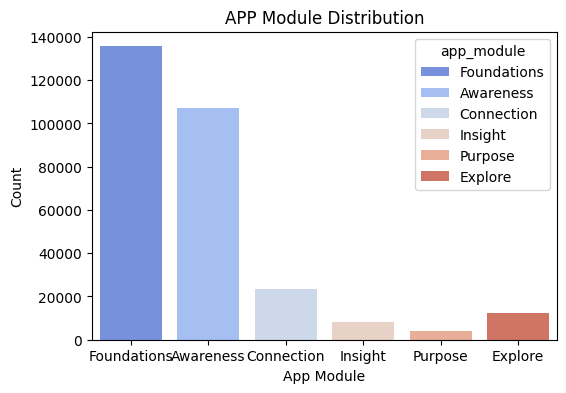

In [37]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['app_module'], palette='coolwarm', hue = df['app_module'])
plt.title('APP Module Distribution')
plt.xlabel('App Module')
plt.ylabel('Count')
plt.show()

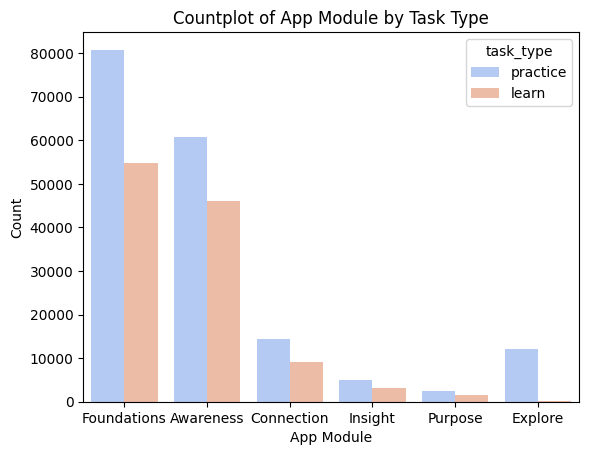

In [38]:
sns.countplot(data=df, x='app_module', palette='coolwarm', hue='task_type')
plt.title('Countplot of App Module by Task Type')
plt.xlabel('App Module')
plt.ylabel('Count')
plt.show()

## Part 4: Create new variables

### create the 'time_of_day' categorical variable, and 'time_practice_most'

In [41]:
df['hour'] = pd.to_datetime(df['engage_time'], format="%H:%M:%S", errors='coerce').dt.hour

# Define categorical bins (common choice)
def hour_to_tod(hour):
    if pd.isnull(hour):
        return np.nan
    if 5 <= hour <= 11:
        return 'morning'   # 05:00-11:59
    if 12 <= hour <= 17:
        return 'afternoon' # 12:00-17:59
    return 'evening'   # 18:00-04:59

df['time_of_day'] = df['hour'].apply(hour_to_tod)

# Example: check counts per bin
df['time_of_day'].value_counts()

time_of_day
evening      116092
afternoon     98189
morning       76468
Name: count, dtype: int64

In [42]:
# count how many times each user practiced in each time_of_day
counts = df.groupby(['user_id', 'time_of_day']).size().reset_index(name='count')

# find which time_of_day each user did most often
most_common = (
    counts.sort_values(['user_id', 'count'], ascending=[True, False])
           .drop_duplicates(subset='user_id')
           .rename(columns={'time_of_day': 'time_practice_most'})
           [['user_id', 'time_practice_most']]
)

# merge that result back to the original dataframe
df = df.merge(most_common, on='user_id', how='left')

df.head(5)

,user_id,completion_date,task_type,app_module,app_part,app_series,activity_name,activity_status,reformatted_date_t0,reformatted_date_t1,reformatted_date_t2,engage_date_reformat,engage_date,engage_time,reformatted_completion_date,time_phrase,hour,time_of_day,time_practice_most
0,us-east-1:fffa06e1-5219-4aaf-bd9c-fc82db7c951f,1.650492e+09,practice,Foundations,Get Started,INTRODUCTION,Intro to Sitting Meditation,Completed,2022-04-19,2022-08-25,2022-12-08,2022-04-20 21:54:01.714999914+00:00,2022-04-20,21:54:01,2022-04-20,1,21,evening,evening
1,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655412e+09,learn,Foundations,Get Started,INTRODUCTION,"Train the Mind, Rewire the Brain",Completed,2022-06-15,2022-07-14,2022-08-11,2022-06-16 20:33:22.494999886+00:00,2022-06-16,20:33:22,2022-06-16,1,20,evening,morning
2,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655467e+09,practice,Foundations,Get Started,INTRODUCTION,Intro to Active Meditation,Completed,2022-06-15,2022-07-14,2022-08-11,2022-06-17 11:52:22.319999933+00:00,2022-06-17,11:52:22,2022-06-17,1,11,morning,morning
3,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655752e+09,practice,Foundations,Awareness Foundations,Introducing Awareness,A Tour of the Senses,Completed,2022-06-15,2022-07-14,2022-08-11,2022-06-20 19:05:22.052999973+00:00,2022-06-20,19:05:22,2022-06-20,1,19,evening,morning
4,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655833e+09,learn,Foundations,Awareness Foundations,Introducing Awareness,The Pull of Distraction,Completed,2022-06-15,2022-07-14,2022-08-11,2022-06-21 17:38:54.733000040+00:00,2022-06-21,17:38:54,2022-06-21,1,17,afternoon,morning


### create 'activity_count_all'

In [44]:
counts = df.groupby("user_id").size()
df["activity_count_all"] = df["user_id"].map(counts)
df.shape # output: (290749, 20)

(290749, 20)

In [45]:
df.head(5)

,user_id,completion_date,task_type,app_module,app_part,app_series,activity_name,activity_status,reformatted_date_t0,reformatted_date_t1,reformatted_date_t2,engage_date_reformat,engage_date,engage_time,reformatted_completion_date,time_phrase,hour,time_of_day,time_practice_most,activity_count_all
0,us-east-1:fffa06e1-5219-4aaf-bd9c-fc82db7c951f,1.650492e+09,practice,Foundations,Get Started,INTRODUCTION,Intro to Sitting Meditation,Completed,2022-04-19,2022-08-25,2022-12-08,2022-04-20 21:54:01.714999914+00:00,2022-04-20,21:54:01,2022-04-20,1,21,evening,evening,1
1,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655412e+09,learn,Foundations,Get Started,INTRODUCTION,"Train the Mind, Rewire the Brain",Completed,2022-06-15,2022-07-14,2022-08-11,2022-06-16 20:33:22.494999886+00:00,2022-06-16,20:33:22,2022-06-16,1,20,evening,morning,62
2,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655467e+09,practice,Foundations,Get Started,INTRODUCTION,Intro to Active Meditation,Completed,2022-06-15,2022-07-14,2022-08-11,2022-06-17 11:52:22.319999933+00:00,2022-06-17,11:52:22,2022-06-17,1,11,morning,morning,62
3,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655752e+09,practice,Foundations,Awareness Foundations,Introducing Awareness,A Tour of the Senses,Completed,2022-06-15,2022-07-14,2022-08-11,2022-06-20 19:05:22.052999973+00:00,2022-06-20,19:05:22,2022-06-20,1,19,evening,morning,62
4,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655833e+09,learn,Foundations,Awareness Foundations,Introducing Awareness,The Pull of Distraction,Completed,2022-06-15,2022-07-14,2022-08-11,2022-06-21 17:38:54.733000040+00:00,2022-06-21,17:38:54,2022-06-21,1,17,afternoon,morning,62


In [46]:
# count how many times each user practiced in each time_of_day
counts = df.groupby(['user_id', 'time_of_day']).size().reset_index(name='count')

# find the most frequent time_of_day for each user
most_common = (
    counts.sort_values(['user_id', 'count'], ascending=[True, False])
           .drop_duplicates(subset='user_id')
           .rename(columns={'time_of_day': 'time_practice_most'})
           [['user_id', 'time_practice_most']]
)

activity_counts = df[['user_id', 'activity_count_all']]

# merge the two summaries into df_1
df_1 = pd.merge(activity_counts, most_common, on='user_id', how='left')

df_1 = df_1.drop_duplicates()
df_1 # output: 8499 rows × 3 columns

,user_id,activity_count_all,time_practice_most
0,us-east-1:fffa06e1-5219-4aaf-bd9c-fc82db7c951f,1,evening
1,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,62,morning
22,us-east-1:80d81114-c846-43e8-a51b-1026df9016e4,14,morning
23,us-east-1:80d67918-e0f8-48f8-93f7-4fd4e8365fba,28,morning
32,us-east-1:f2ba6a4f-36cb-4b0d-b089-bb6355f3e3cb,5,evening
...,...,...,...
289638,us-east-1:9d8b44d2-c5a9-44fe-8a1d-da6887d03ff6,1,morning
289805,us-east-1:f25c01d5-e1be-465b-a27a-f7f5e04e839b,1,afternoon
290017,us-east-1:80b9085c-f027-4db0-af5b-fcbecdfe4ce5,3,afternoon
290202,us-east-1:8348d6b8-4077-4117-bf48-36a0d3d15eec,1,morning


In [47]:
df_1['activity_count_all'].value_counts() 

activity_count_all
1      372
2      281
4      223
3      221
7      203
      ... 
224      1
179      1
235      1
321      1
199      1
Name: count, Length: 221, dtype: int64

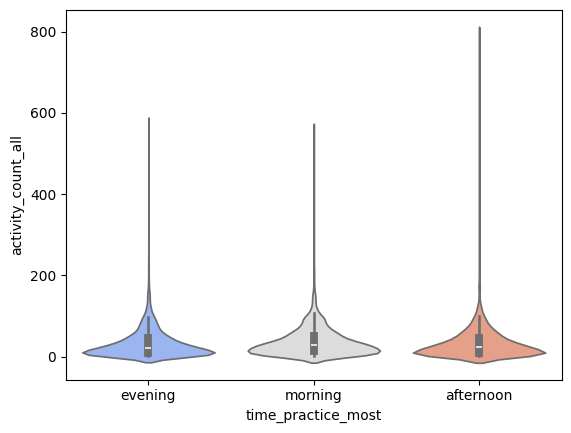

In [48]:
sns.violinplot(x='time_practice_most', y='activity_count_all', data=df_1, hue = "time_practice_most", palette='coolwarm')
plt.show()

### Outliers

In [50]:
# show all rows with 'activity_count_all' greater than 400
df_1[df_1['activity_count_all'] > 400]

,user_id,activity_count_all,time_practice_most
3726,us-east-1:87623707-a7b3-469c-b4b3-cc576e77d4b7,558,morning
53661,us-east-1:c92ad11e-a905-47f9-b5a4-1c2c144dd470,595,afternoon
72077,us-east-1:a9faa455-05cf-40f1-9fc7-1e9c5154ee13,402,evening
74282,us-east-1:9ec8d9f0-79d0-4e72-ace7-98c8c15ea981,463,evening
86368,us-east-1:aedc23f8-7bc7-4994-807f-b6f95f8c9ab7,431,afternoon
104439,us-east-1:15e4349d-97b0-46e6-a7a5-d0cde31ae78b,796,afternoon
119583,us-east-1:46857bca-b098-481c-8ad4-72952cf485bf,574,evening


In [51]:
df[df['user_id'] == 'us-east-1:15e4349d-97b0-46e6-a7a5-d0cde31ae78b']

,user_id,completion_date,task_type,app_module,app_part,app_series,activity_name,activity_status,reformatted_date_t0,reformatted_date_t1,reformatted_date_t2,engage_date_reformat,engage_date,engage_time,reformatted_completion_date,time_phrase,hour,time_of_day,time_practice_most,activity_count_all
104439,us-east-1:15e4349d-97b0-46e6-a7a5-d0cde31ae78b,1.669312e+09,learn,Foundations,Awareness Foundations,Introducing Awareness,The Pull of Distraction,Completed,2022-11-17,2023-03-10,2023-04-08,2022-11-24 17:50:24.625000+00:00,2022-11-24,17:50:24,2022-11-24,1,17,afternoon,afternoon,796
104440,us-east-1:15e4349d-97b0-46e6-a7a5-d0cde31ae78b,1.669313e+09,practice,Foundations,Awareness Foundations,Introducing Awareness,The Skill of Attention,Completed,2022-11-17,2023-03-10,2023-04-08,2022-11-24 18:06:15.852999926+00:00,2022-11-24,18:06:15,2022-11-24,1,18,evening,afternoon,796
104441,us-east-1:15e4349d-97b0-46e6-a7a5-d0cde31ae78b,1.669387e+09,practice,Foundations,Connection Foundations,Introducing Connection,Compassion,Completed,2022-11-17,2023-03-10,2023-04-08,2022-11-25 14:37:16.559000015+00:00,2022-11-25,14:37:16,2022-11-25,1,14,afternoon,afternoon,796
104442,us-east-1:15e4349d-97b0-46e6-a7a5-d0cde31ae78b,1.669402e+09,practice,Foundations,Get Started,INTRODUCTION,Intro to Sitting Meditation,Completed,2022-11-17,2023-03-10,2023-04-08,2022-11-25 18:46:47.605000019+00:00,2022-11-25,18:46:47,2022-11-25,1,18,evening,afternoon,796
104443,us-east-1:15e4349d-97b0-46e6-a7a5-d0cde31ae78b,1.669402e+09,practice,Foundations,Awareness Foundations,Introducing Awareness,The Skill of Mindfulness,Completed,2022-11-17,2023-03-10,2023-04-08,2022-11-25 18:52:10.341000080+00:00,2022-11-25,18:52:10,2022-11-25,1,18,evening,afternoon,796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263748,us-east-1:15e4349d-97b0-46e6-a7a5-d0cde31ae78b,1.676284e+09,practice,Connection,Appreciation,Series 1: Innate Self-Worth,Self-Worth,Completed,2022-11-17,2023-03-10,2023-04-08,2023-02-13 10:27:06.640000105+00:00,2023-02-13,10:27:06,2023-02-13,1,10,morning,afternoon,796
263750,us-east-1:15e4349d-97b0-46e6-a7a5-d0cde31ae78b,1.676549e+09,learn,Connection,Appreciation,Series 1: Innate Self-Worth,Noticing the Positive,Completed,2022-11-17,2023-03-10,2023-04-08,2023-02-16 12:10:37.365000010+00:00,2023-02-16,12:10:37,2023-02-16,1,12,afternoon,afternoon,796
277957,us-east-1:15e4349d-97b0-46e6-a7a5-d0cde31ae78b,1.679754e+09,practice,Purpose,Clarity of Purpose,Series 2: Clarity of Purpose,"One Act, Many Motivations",Completed,2022-11-17,2023-03-10,2023-04-08,2023-03-25 14:14:05.111999989+00:00,2023-03-25,14:14:05,2023-03-25,2,14,afternoon,afternoon,796
277958,us-east-1:15e4349d-97b0-46e6-a7a5-d0cde31ae78b,1.679753e+09,learn,Purpose,Clarity of Purpose,Series 2: Clarity of Purpose,"One Act, Many Motivations",Completed,2022-11-17,2023-03-10,2023-04-08,2023-03-25 14:03:23.657999992+00:00,2023-03-25,14:03:23,2023-03-25,2,14,afternoon,afternoon,796


In [52]:
# exclude activity_count_all greater than 3 standard deviation mean
# Calculate mean and standard deviation
mean_val = df_1['activity_count_all'].mean()
std_val = df_1['activity_count_all'].std()

# Filter out values greater than mean + 3*std
df_1 = df_1[df_1['activity_count_all'] <= mean_val + 3 * std_val]

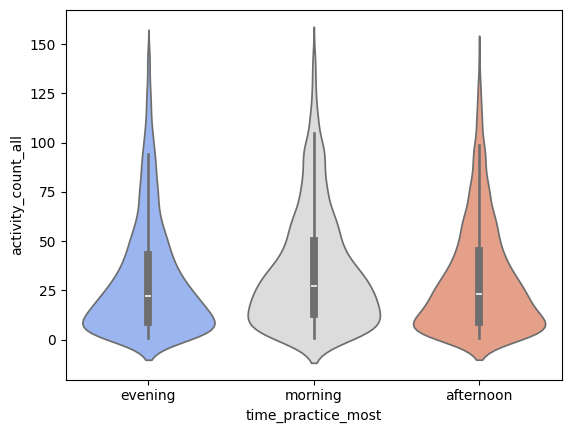

In [53]:
sns.violinplot(x='time_practice_most', y='activity_count_all', data=df_1, hue = "time_practice_most", palette='coolwarm')
plt.show()

### Create engagement metric scores

In [55]:
df.head()

,user_id,completion_date,task_type,app_module,app_part,app_series,activity_name,activity_status,reformatted_date_t0,reformatted_date_t1,reformatted_date_t2,engage_date_reformat,engage_date,engage_time,reformatted_completion_date,time_phrase,hour,time_of_day,time_practice_most,activity_count_all
0,us-east-1:fffa06e1-5219-4aaf-bd9c-fc82db7c951f,1.650492e+09,practice,Foundations,Get Started,INTRODUCTION,Intro to Sitting Meditation,Completed,2022-04-19,2022-08-25,2022-12-08,2022-04-20 21:54:01.714999914+00:00,2022-04-20,21:54:01,2022-04-20,1,21,evening,evening,1
1,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655412e+09,learn,Foundations,Get Started,INTRODUCTION,"Train the Mind, Rewire the Brain",Completed,2022-06-15,2022-07-14,2022-08-11,2022-06-16 20:33:22.494999886+00:00,2022-06-16,20:33:22,2022-06-16,1,20,evening,morning,62
2,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655467e+09,practice,Foundations,Get Started,INTRODUCTION,Intro to Active Meditation,Completed,2022-06-15,2022-07-14,2022-08-11,2022-06-17 11:52:22.319999933+00:00,2022-06-17,11:52:22,2022-06-17,1,11,morning,morning,62
3,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655752e+09,practice,Foundations,Awareness Foundations,Introducing Awareness,A Tour of the Senses,Completed,2022-06-15,2022-07-14,2022-08-11,2022-06-20 19:05:22.052999973+00:00,2022-06-20,19:05:22,2022-06-20,1,19,evening,morning,62
4,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655833e+09,learn,Foundations,Awareness Foundations,Introducing Awareness,The Pull of Distraction,Completed,2022-06-15,2022-07-14,2022-08-11,2022-06-21 17:38:54.733000040+00:00,2022-06-21,17:38:54,2022-06-21,1,17,afternoon,morning,62


In [56]:
# 1. Clean and standardize text
df['task_type'] = df['task_type'].astype(str).str.strip().str.lower()
df['module_name'] = df['app_module'].astype(str).str.strip().str.title()

# 2. Keep only the 6 core modules and 2 valid task types
modules = ["Foundations", "Awareness", "Connection", "Explore", "Insight", "Purpose"]
valid_task_types = ['learn', 'practice']

df_clean = df[
    df['module_name'].isin(modules) &
    df['task_type'].isin(valid_task_types)
].copy()

# 3. Remove duplicates (so repeating same module+task_type doesn't overcount)
df_unique = df_clean.drop_duplicates(subset=['user_id', 'task_type', 'module_name'])

# 4. Count total unique (task_type × module_name) combinations per user
user_scores = (
    df_unique.groupby('user_id')
    .size()
    .reset_index(name='total_score')
)

user_scores # output: 8499 rows × 2 columns

,user_id,total_score
0,us-east-1:0004187c-f54f-4590-bde8-9cd9cc375b7f,5
1,us-east-1:00198846-bbca-4e33-9420-d3d0413b4858,4
2,us-east-1:001d3487-2fa2-429b-bdb1-509b1840d7c6,4
3,us-east-1:0033b748-f290-4b4c-a6e9-61fc7839e37a,2
4,us-east-1:003820ca-07dd-40f9-b282-4ab65b02dfa2,10
...,...,...
8494,us-east-1:ffe47cd3-d901-4617-b457-a2fbc0ea77c9,2
8495,us-east-1:ffe65c7f-2455-497e-9946-7b7024716ae2,2
8496,us-east-1:ffea8ac5-d7af-495f-ba4c-1ea85b068f65,2
8497,us-east-1:fff29fd9-f458-423d-8679-a12298c43baf,3


In [57]:
# Merge user_scores back to the original df by user_id
df = df.merge(user_scores[['user_id', 'total_score']], on='user_id', how='left')
df # output: 290749 rows × 22 columns

,user_id,completion_date,task_type,app_module,app_part,app_series,activity_name,activity_status,reformatted_date_t0,reformatted_date_t1,...,engage_date,engage_time,reformatted_completion_date,time_phrase,hour,time_of_day,time_practice_most,activity_count_all,module_name,total_score
0,us-east-1:fffa06e1-5219-4aaf-bd9c-fc82db7c951f,1.650492e+09,practice,Foundations,Get Started,INTRODUCTION,Intro to Sitting Meditation,Completed,2022-04-19,2022-08-25,...,2022-04-20,21:54:01,2022-04-20,1,21,evening,evening,1,Foundations,1
1,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655412e+09,learn,Foundations,Get Started,INTRODUCTION,"Train the Mind, Rewire the Brain",Completed,2022-06-15,2022-07-14,...,2022-06-16,20:33:22,2022-06-16,1,20,evening,morning,62,Foundations,4
2,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655467e+09,practice,Foundations,Get Started,INTRODUCTION,Intro to Active Meditation,Completed,2022-06-15,2022-07-14,...,2022-06-17,11:52:22,2022-06-17,1,11,morning,morning,62,Foundations,4
3,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655752e+09,practice,Foundations,Awareness Foundations,Introducing Awareness,A Tour of the Senses,Completed,2022-06-15,2022-07-14,...,2022-06-20,19:05:22,2022-06-20,1,19,evening,morning,62,Foundations,4
4,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,1.655833e+09,learn,Foundations,Awareness Foundations,Introducing Awareness,The Pull of Distraction,Completed,2022-06-15,2022-07-14,...,2022-06-21,17:38:54,2022-06-21,1,17,afternoon,morning,62,Foundations,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290744,us-east-1:118f03ac-e618-405f-a6fb-92fcb4a76b20,1.676232e+09,learn,NaN,NaN,NaN,Awareness: The First Pillar of Well-Being,Completed,2023-01-15,2023-02-13,...,2023-02-12,20:06:16,2023-02-12,1,20,evening,evening,178,Nan,10
290745,us-east-1:118f03ac-e618-405f-a6fb-92fcb4a76b20,1.676253e+09,learn,NaN,NaN,NaN,Awareness: The First Pillar of Well-Being,Completed,2023-01-15,2023-02-13,...,2023-02-13,01:54:20,2023-02-13,2,1,evening,evening,178,Nan,10
290746,us-east-1:118f03ac-e618-405f-a6fb-92fcb4a76b20,1.676254e+09,practice,NaN,NaN,NaN,Awareness: The First Pillar of Well-Being,Completed,2023-01-15,2023-02-13,...,2023-02-13,02:04:39,2023-02-13,2,2,evening,evening,178,Nan,10
290747,us-east-1:4c28466c-9262-4b93-aa50-51bf0bc3c449,1.689949e+09,practice,NaN,NaN,NaN,Connection: The Second Pillar of Well-Being,Completed,2023-07-17,2023-08-16,...,2023-07-21,14:10:27,2023-07-21,1,14,afternoon,morning,84,Nan,10


In [58]:
df_2 = user_scores.merge(df[['user_id', 'time_practice_most']], on='user_id', how='left')
df_2 = df_2.drop_duplicates()
df_2 # output: 8499 rows × 3 columns

,user_id,total_score,time_practice_most
0,us-east-1:0004187c-f54f-4590-bde8-9cd9cc375b7f,5,afternoon
31,us-east-1:00198846-bbca-4e33-9420-d3d0413b4858,4,evening
55,us-east-1:001d3487-2fa2-429b-bdb1-509b1840d7c6,4,afternoon
124,us-east-1:0033b748-f290-4b4c-a6e9-61fc7839e37a,2,morning
130,us-east-1:003820ca-07dd-40f9-b282-4ab65b02dfa2,10,afternoon
...,...,...,...
290717,us-east-1:ffe47cd3-d901-4617-b457-a2fbc0ea77c9,2,evening
290730,us-east-1:ffe65c7f-2455-497e-9946-7b7024716ae2,2,morning
290733,us-east-1:ffea8ac5-d7af-495f-ba4c-1ea85b068f65,2,morning
290742,us-east-1:fff29fd9-f458-423d-8679-a12298c43baf,3,evening


## Part 5: Simple Models

In [60]:
model_1 = smf.glm(
    formula="activity_count_all ~ C(time_practice_most)",
    data=df_1, # user_id + activity_count_all + time_practice_most - (activity_count_all > 3 SD)
    family=sm.families.NegativeBinomial()
).fit()

model_1.summary()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     activity_count_all   No. Observations:                 8382
Model:                            GLM   Df Residuals:                     8379
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -37468.
Date:                Sat, 22 Nov 2025   Deviance:                       7984.6
Time:                        17:02:13   Pearson chi2:                 6.61e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.003091
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            3.4218      0.019    178.844      0.000       3.384       3.459
C(time_practice_most)[T.evening]     0.0028      0.026      0.108      0.914      -0.047       0.053
C(time_practice_most)[T.morning]     0.1330      0.030      4.470      0.000       0.075       0.191
====================================================================================================
"""

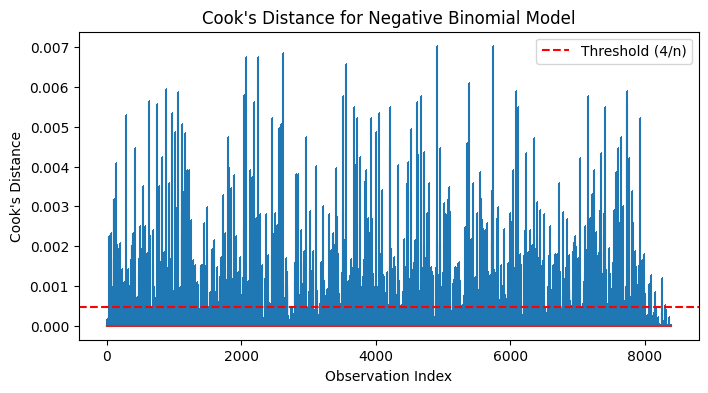

In [61]:
# Check cook's distance
# Get influence measures
influence = model_1.get_influence()

# Cook’s distance
cooks_d = influence.cooks_distance[0]

threshold = 4 / len(df_1)

plt.figure(figsize=(8,4))
plt.stem(np.arange(len(df_1)), cooks_d, markerfmt=",")
plt.axhline(y=threshold, color="red", linestyle="--", label="Threshold (4/n)")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Negative Binomial Model")
plt.legend()
plt.show()

In [62]:
model_2 = smf.glm(
    formula="total_score ~ C(time_practice_most)",
    data=df_2, 
    family=sm.families.NegativeBinomial()
).fit()

model_2.summary()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_score   No. Observations:                 8499
Model:                            GLM   Df Residuals:                     8496
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20872.
Date:                Sat, 22 Nov 2025   Deviance:                       1858.4
Time:                        17:02:14   Pearson chi2:                 1.98e+03
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0005617
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.3082      0.021     62.050      0.000       1.267       1.350
C(time_practice_most)[T.evening]     0.0221      0.028      0.787      0.432      -0.033       0.077
C(time_practice_most)[T.morning]     0.0706      0.033      2.161      0.031       0.007       0.135
====================================================================================================
"""

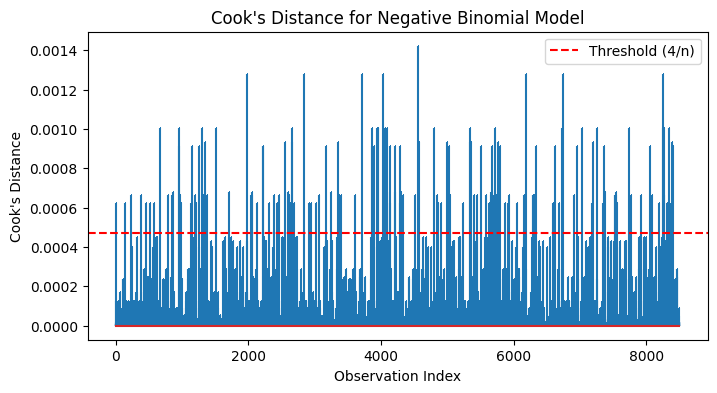

In [63]:
# Check cook's distance
# Get influence measures
influence_2 = model_2.get_influence()

# Cook’s distance
cooks_d_2 = influence_2.cooks_distance[0]

threshold_2 = 4 / len(df_2)

plt.figure(figsize=(8,4))
plt.stem(np.arange(len(df_2)), cooks_d_2, markerfmt=",")
plt.axhline(y=threshold_2, color="red", linestyle="--", label="Threshold (4/n)")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Negative Binomial Model")
plt.legend()
plt.show()

In [64]:
len(df_1)

8382

In [65]:
len(df_2)

8499

## Part 6: Adding Demographic as Covariate in Models

In [67]:
demographic = pd.read_csv('hmi_rq2_all.csv')
demographic

,user_id,activity_count_all,education,age,relationship,gender,race
0,us-east-1:0004187c-f54f-4590-bde8-9cd9cc375b7f,33,bachelors_degree,25-34,divorced,female,white
1,us-east-1:00198846-bbca-4e33-9420-d3d0413b4858,25,advanced_degree,35-44,married_domestic_part,male,white
2,us-east-1:001a15a1-2724-47c3-9848-ac6202290557,1,high_school,55-64,married_domestic_part,male,white
3,us-east-1:00216bfb-9986-4249-af99-5ae1b3649c5b,19,high_school,25-34,widowed,male,hisp_latin_span
4,us-east-1:002cbcff-b378-4cf0-8094-8018c2c511b1,23,advanced_degree,35-44,married_domestic_part,female,white
...,...,...,...,...,...,...,...
12117,us-east-1:ffe9177d-7ed3-43ce-bf82-fdbe20bc92b2,23,some_college_or_associates,45-54,married_domestic_part,male,white
12118,us-east-1:ffea8ac5-d7af-495f-ba4c-1ea85b068f65,9,bachelors_degree,45-54,married_domestic_part,female,white
12119,us-east-1:fff1ca6f-fb56-469e-9b42-914de822f9c5,23,advanced_degree,25-34,committed,female,white
12120,us-east-1:fff29fd9-f458-423d-8679-a12298c43baf,6,advanced_degree,35-44,single_never_married,female,white


### Recategorize Gender

In [69]:
gender_collapse_map = {
    "female": "female",
    "male": "male",
    "fluid_nonbinary": "other",
    "unknown": "other"
}

demographic["gender"] = demographic["gender"].replace(gender_collapse_map)
demographic = demographic.drop(columns=['activity_count_all'], errors='ignore')
demographic

,user_id,education,age,relationship,gender,race
0,us-east-1:0004187c-f54f-4590-bde8-9cd9cc375b7f,bachelors_degree,25-34,divorced,female,white
1,us-east-1:00198846-bbca-4e33-9420-d3d0413b4858,advanced_degree,35-44,married_domestic_part,male,white
2,us-east-1:001a15a1-2724-47c3-9848-ac6202290557,high_school,55-64,married_domestic_part,male,white
3,us-east-1:00216bfb-9986-4249-af99-5ae1b3649c5b,high_school,25-34,widowed,male,hisp_latin_span
4,us-east-1:002cbcff-b378-4cf0-8094-8018c2c511b1,advanced_degree,35-44,married_domestic_part,female,white
...,...,...,...,...,...,...
12117,us-east-1:ffe9177d-7ed3-43ce-bf82-fdbe20bc92b2,some_college_or_associates,45-54,married_domestic_part,male,white
12118,us-east-1:ffea8ac5-d7af-495f-ba4c-1ea85b068f65,bachelors_degree,45-54,married_domestic_part,female,white
12119,us-east-1:fff1ca6f-fb56-469e-9b42-914de822f9c5,advanced_degree,25-34,committed,female,white
12120,us-east-1:fff29fd9-f458-423d-8679-a12298c43baf,advanced_degree,35-44,single_never_married,female,white


### Check Age

In [71]:
demographic['age'].value_counts()

age
25-34          2568
35-44          2542
45-54          2414
55-64          1871
unknown        1468
65-74           983
75_or_older     276
Name: count, dtype: int64

In [72]:
demographic['age'].isna().sum()

np.int64(0)

In [73]:
# reorder age
age_order = ['25-34', '34-44', '45-54', '55-64', '65-74', '75_or_older', 'unknown']

demographic["age"] = pd.Categorical(
    demographic["age"],
    categories=age_order,
    ordered=True
)

### Check race

In [75]:
demographic['race'].value_counts()

race
white                  8764
asian                   791
hisp_latin_span         770
other                   587
prefer_not_to_say       472
black_afr_amer          354
mid_east_north_afr      244
am_indian_ak_native      64
unknown                  50
nat_hi_pac_isl           26
Name: count, dtype: int64

### Merge activity_count_all (df_1) with demographics

In [77]:
df_1 # 8382 rows × 3 columns

,user_id,activity_count_all,time_practice_most
0,us-east-1:fffa06e1-5219-4aaf-bd9c-fc82db7c951f,1,evening
1,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,62,morning
22,us-east-1:80d81114-c846-43e8-a51b-1026df9016e4,14,morning
23,us-east-1:80d67918-e0f8-48f8-93f7-4fd4e8365fba,28,morning
32,us-east-1:f2ba6a4f-36cb-4b0d-b089-bb6355f3e3cb,5,evening
...,...,...,...
289638,us-east-1:9d8b44d2-c5a9-44fe-8a1d-da6887d03ff6,1,morning
289805,us-east-1:f25c01d5-e1be-465b-a27a-f7f5e04e839b,1,afternoon
290017,us-east-1:80b9085c-f027-4db0-af5b-fcbecdfe4ce5,3,afternoon
290202,us-east-1:8348d6b8-4077-4117-bf48-36a0d3d15eec,1,morning


In [78]:
df_merged_all_activity = pd.merge(df_1, demographic, on="user_id", how="left") 
df_merged_all_activity 
# outer join:13732 rows × 8 columns
# left join: 8382 rows × 8 columns
# inner join: 6772 rows × 8 columns

,user_id,activity_count_all,time_practice_most,education,age,relationship,gender,race
0,us-east-1:fffa06e1-5219-4aaf-bd9c-fc82db7c951f,1,evening,advanced_degree,unknown,prefer_not_to_say,other,nat_hi_pac_isl
1,us-east-1:80d967c7-fc97-4467-b25e-85813ce7c309,62,morning,NaN,NaN,NaN,NaN,NaN
2,us-east-1:80d81114-c846-43e8-a51b-1026df9016e4,14,morning,advanced_degree,65-74,divorced,female,white
3,us-east-1:80d67918-e0f8-48f8-93f7-4fd4e8365fba,28,morning,some_college_or_associates,45-54,married_domestic_part,female,white
4,us-east-1:f2ba6a4f-36cb-4b0d-b089-bb6355f3e3cb,5,evening,bachelors_degree,25-34,committed,female,white
...,...,...,...,...,...,...,...,...
8377,us-east-1:9d8b44d2-c5a9-44fe-8a1d-da6887d03ff6,1,morning,NaN,NaN,NaN,NaN,NaN
8378,us-east-1:f25c01d5-e1be-465b-a27a-f7f5e04e839b,1,afternoon,bachelors_degree,NaN,married_domestic_part,female,white
8379,us-east-1:80b9085c-f027-4db0-af5b-fcbecdfe4ce5,3,afternoon,bachelors_degree,unknown,single_never_married,female,asian
8380,us-east-1:8348d6b8-4077-4117-bf48-36a0d3d15eec,1,morning,bachelors_degree,55-64,married_domestic_part,female,white


In [79]:
df_merged_all_activity.describe()

,activity_count_all
count,8382.000000
mean,31.690050
std,28.547674
min,1.000000
25%,10.000000
50%,23.000000
75%,45.000000
max,146.000000


/var/folders/t5/jyb99b0d5rd5j2hh_d16njs40000gn/T/ipykernel_14313/3203219376.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="time_practice_most", y="activity_count_all", data=df_merged_all_activity, inner="box", palette="Pastel1")


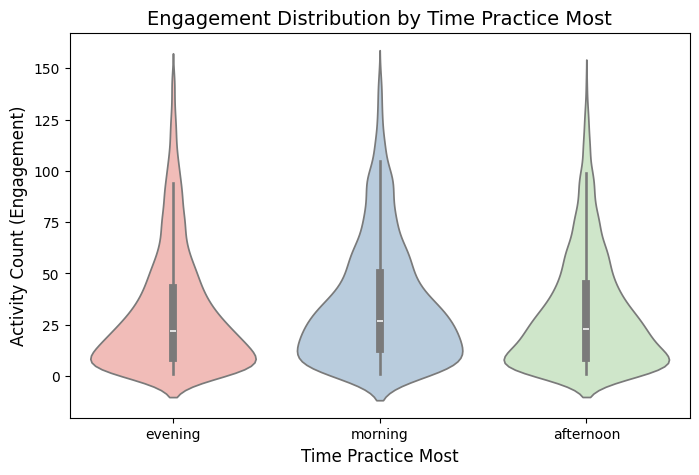

In [80]:
plt.figure(figsize=(8, 5))
sns.violinplot(x="time_practice_most", y="activity_count_all", data=df_merged_all_activity, inner="box", palette="Pastel1")

plt.title("Engagement Distribution by Time Practice Most", fontsize=14)
plt.xlabel("Time Practice Most", fontsize=12)
plt.ylabel("Activity Count (Engagement)", fontsize=12)
plt.show()

### Check Correlation

In [82]:
# check correlation
model = ols('activity_count_all ~ C(education)', data=df_merged_all_activity).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
eta_sq = anova_table['sum_sq']['C(education)'] / sum(anova_table['sum_sq'])
print("Eta squared:", eta_sq)

Eta squared: 0.007422622767921129


In [83]:
model = ols('activity_count_all ~ C(age)', data=df_merged_all_activity).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
eta_sq = anova_table['sum_sq']['C(age)'] / sum(anova_table['sum_sq'])
print("Eta squared:", eta_sq)

Eta squared: 0.02283656783974558


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  warnings.warn('covariance of constraints does not have full '


In [84]:
model = ols('activity_count_all ~ C(gender)', data=df_merged_all_activity).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
eta_sq = anova_table['sum_sq']['C(gender)'] / sum(anova_table['sum_sq'])
print("Eta squared:", eta_sq)

Eta squared: 0.0022504705478572033


In [85]:
model = ols('activity_count_all ~ C(race)', data=df_merged_all_activity).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
eta_sq = anova_table['sum_sq']['C(race)'] / sum(anova_table['sum_sq'])
print("Eta squared:", eta_sq)

Eta squared: 0.0032911816044829166


In [86]:
model = ols('activity_count_all ~ C(time_practice_most)', data=df_merged_all_activity).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
eta_sq = anova_table['sum_sq']['C(time_practice_most)'] / sum(anova_table['sum_sq'])
print("Eta squared:", eta_sq)

Eta squared: 0.004113682453507266


### Adding Age as Covariate

In [88]:
# no need to model since eta squared is too small, only age's eta squared > 0.01 show small correlation
model_cov_1 = smf.glm(
    formula="activity_count_all ~ C(time_practice_most) + C(age)",
    data=df_merged_all_activity,
    family=sm.families.NegativeBinomial()
).fit()

model_cov_1.summary()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     activity_count_all   No. Observations:                 5304
Model:                            GLM   Df Residuals:                     5296
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23589.
Date:                Sat, 22 Nov 2025   Deviance:                       5002.1
Time:                        17:02:16   Pearson chi2:                 4.10e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01875
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            3.3306      0.034     98.378      0.000       3.264       3.397
C(time_practice_most)[T.evening]    -0.0226      0.032     -0.702      0.483      -0.086       0.040
C(time_practice_most)[T.morning]     0.1199      0.038      3.184      0.001       0.046       0.194
C(age)[T.34-44]                   1.011e-15   1.63e-16      6.198      0.000    6.91e-16    1.33e-15
C(age)[T.45-54]                      0.1340      0.039      3.475      0.001       0.058       0.210
C(age)[T.55-64]                      0.1944      0.042      4.623      0.000       0.112       0.277
C(age)[T.65-74]                      0.2806      0.052      5.409      0.000       0.179       0.382
C(age)[T.75_or_older]                0.1532      0.085      1.802      0.072      -0.013       0.320
C(age)[T.unknown]                   -0.1439      0.045     -3.210      0.001      -0.232      -0.056
====================================================================================================
"""

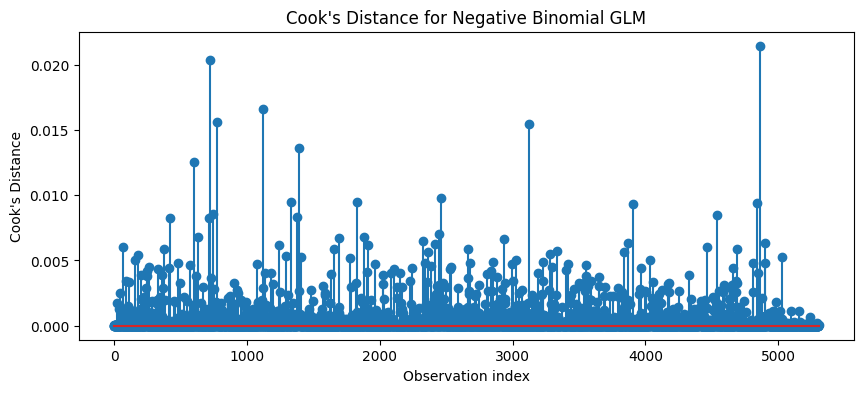

Influential points:
        cooks_d
22    0.001753
41    0.001288
42    0.002494
53    0.000714
54    0.000785
...        ...
5025  0.000539
5028  0.005293
5092  0.001122
5153  0.001142
5240  0.000646

[591 rows x 1 columns]


In [89]:
# Get influence measures
influence = model_cov_1.get_influence()

# Extract Cook's distance
cooks_d = influence.cooks_distance[0]

# Put in DataFrame
cooks_df = pd.DataFrame({"cooks_d": cooks_d})

# Show top influential rows
cooks_df.sort_values("cooks_d", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 4))
plt.stem(cooks_d)
plt.xlabel("Observation index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Negative Binomial GLM")
plt.show()

# Identify influential cases
threshold = 4 / len(df_merged_all_activity)
influential_points = cooks_df[cooks_df["cooks_d"] > threshold]
print("Influential points:\n", influential_points)

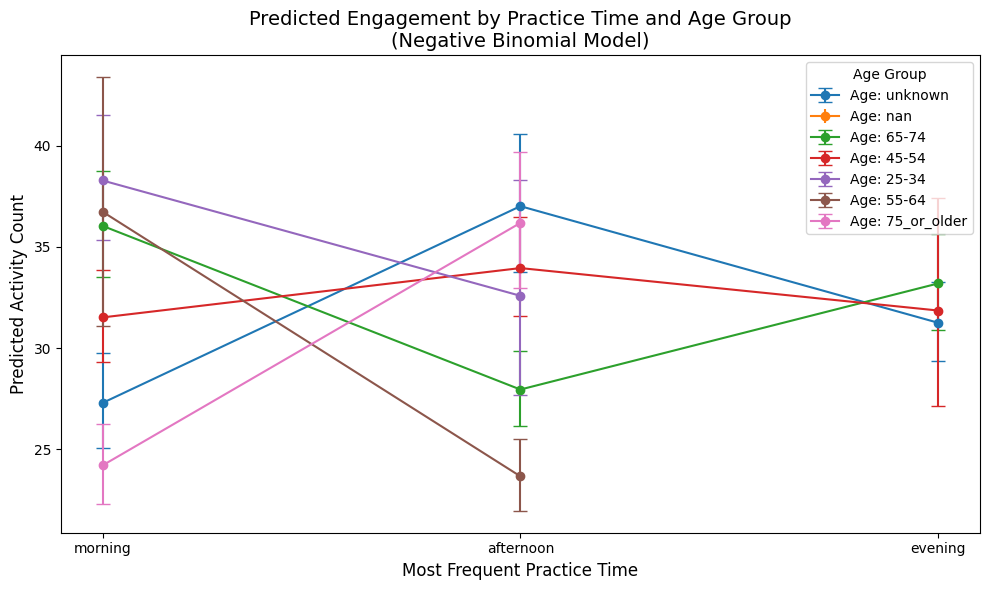

In [90]:
# Step 1. Extract unique categories
time_categories = ['evening', 'afternoon', 'morning']
age_categories = df_merged_all_activity["age"].unique()

# Step 2. Create prediction DataFrame for all combinations
pred_df = pd.DataFrame([(t, a) for t in time_categories for a in age_categories],
                       columns=["time_practice_most", "age"])

order = ["morning", "afternoon", "evening"]
pred_df = pred_df.set_index("time_practice_most").loc[order].reset_index()


# Step 3. Generate predictions
predictions = model_cov_1.get_prediction(pred_df)
pred_summary = predictions.summary_frame(alpha=0.05)

pred_df["predicted"] = pred_summary["mean"]
pred_df["conf_low"] = pred_summary["mean_ci_lower"]
pred_df["conf_high"] = pred_summary["mean_ci_upper"]

# Step 4. Plot results
plt.figure(figsize=(10, 6))
for age_group in age_categories:
    subset = pred_df[pred_df["age"] == age_group]
    plt.errorbar(subset["time_practice_most"], subset["predicted"],
                 yerr=[subset["predicted"] - subset["conf_low"],
                       subset["conf_high"] - subset["predicted"]],
                 capsize=5, marker="o", label=f"Age: {age_group}")

plt.xlabel("Most Frequent Practice Time", fontsize=12)
plt.ylabel("Predicted Activity Count", fontsize=12)
plt.title("Predicted Engagement by Practice Time and Age Group\n(Negative Binomial Model)", fontsize=14)
plt.legend(title="Age Group")
plt.tight_layout()
plt.show()

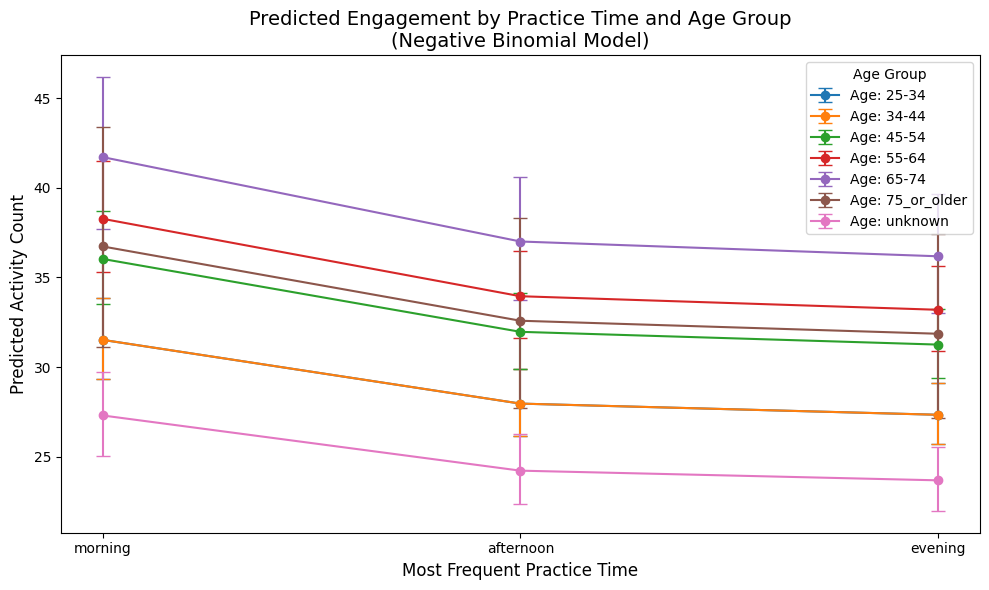

In [91]:
# Step 1. Extract unique categories
time_categories = ['evening', 'afternoon', 'morning']
# Convert age column to ordered categorical
df_merged_all_activity["age"] = pd.Categorical(
    df_merged_all_activity["age"],
    categories=age_order,
    ordered=True
)

# Extract categories in the specified order
age_categories = df_merged_all_activity["age"].cat.categories

# Step 2. Create prediction DataFrame for all combinations
pred_df = pd.DataFrame([(t, a) for t in time_categories for a in age_categories],
                       columns=["time_practice_most", "age"])

order = ["morning", "afternoon", "evening"]
pred_df = pred_df.set_index("time_practice_most").loc[order].reset_index()


# Step 3. Generate predictions
predictions = model_cov_1.get_prediction(pred_df)
pred_summary = predictions.summary_frame(alpha=0.05)

pred_df["predicted"] = pred_summary["mean"]
pred_df["conf_low"] = pred_summary["mean_ci_lower"]
pred_df["conf_high"] = pred_summary["mean_ci_upper"]

# Step 4. Plot results
plt.figure(figsize=(10, 6))
for age_group in age_categories:
    subset = pred_df[pred_df["age"] == age_group]
    plt.errorbar(subset["time_practice_most"], subset["predicted"],
                 yerr=[subset["predicted"] - subset["conf_low"],
                       subset["conf_high"] - subset["predicted"]],
                 capsize=5, marker="o", label=f"Age: {age_group}")

plt.xlabel("Most Frequent Practice Time", fontsize=12)
plt.ylabel("Predicted Activity Count", fontsize=12)
plt.title("Predicted Engagement by Practice Time and Age Group\n(Negative Binomial Model)", fontsize=14)
plt.legend(title="Age Group")
plt.tight_layout()
plt.show()

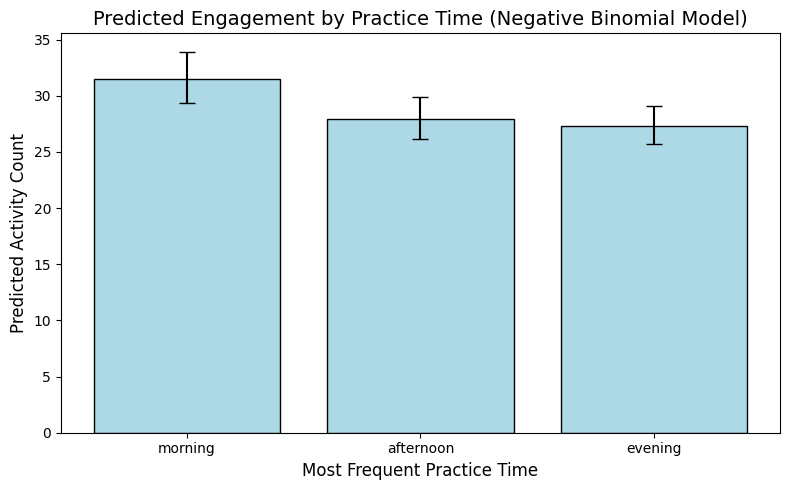

In [157]:
# Step 1. Get unique time categories
time_categories = ['morning', 'afternoon', 'evening']

# Step 2. Choose one reference category for age (e.g., most common)
ref_age = df_merged_all_activity["age"].mode()[0]  # most frequent age category -> '25-34'

# Step 3. Create prediction DataFrame
pred_df = pd.DataFrame({
    "time_practice_most": time_categories,
    "age": [ref_age] * len(time_categories)
})

# Step 4. Generate predictions and confidence intervals
predictions = model_cov_1.get_prediction(pred_df)
pred_summary = predictions.summary_frame(alpha=0.05)

pred_df["predicted"] = pred_summary["mean"]
pred_df["conf_low"] = pred_summary["mean_ci_lower"]
pred_df["conf_high"] = pred_summary["mean_ci_upper"]

# Step 5. Plot predicted values with 95% CI
plt.figure(figsize=(8, 5))
plt.bar(pred_df["time_practice_most"], pred_df["predicted"], 
        yerr=[pred_df["predicted"] - pred_df["conf_low"],
              pred_df["conf_high"] - pred_df["predicted"]],
        capsize=6, color="lightblue", edgecolor="black")

plt.xlabel("Most Frequent Practice Time", fontsize=12)
plt.ylabel("Predicted Activity Count", fontsize=12)
plt.title("Predicted Engagement by Practice Time (Negative Binomial Model)", fontsize=14)
plt.tight_layout()
plt.show()

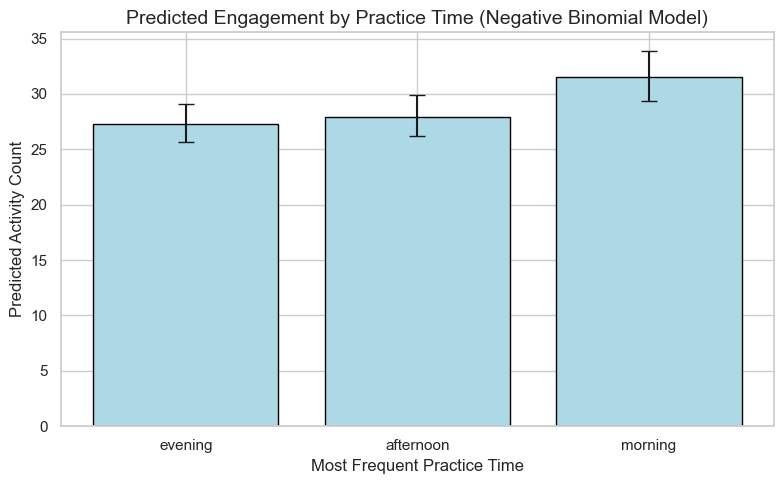

In [220]:
# Step 1. Get unique time categories
time_categories = ['evening', 'afternoon', 'morning']

# Step 2. Choose one reference category for age (e.g., most common)
ref_age = '34-44'  # most frequent age category

# Step 3. Create prediction DataFrame
pred_df = pd.DataFrame({
    "time_practice_most": time_categories,
    "age": [ref_age] * len(time_categories)
})

# Step 4. Generate predictions and confidence intervals
predictions = model_cov_1.get_prediction(pred_df)
pred_summary = predictions.summary_frame(alpha=0.05)

pred_df["predicted"] = pred_summary["mean"]
pred_df["conf_low"] = pred_summary["mean_ci_lower"]
pred_df["conf_high"] = pred_summary["mean_ci_upper"]

# Step 5. Plot predicted values with 95% CI
plt.figure(figsize=(8, 5))
plt.bar(pred_df["time_practice_most"], pred_df["predicted"], 
        yerr=[pred_df["predicted"] - pred_df["conf_low"],
              pred_df["conf_high"] - pred_df["predicted"]],
        capsize=6, color="lightblue", edgecolor="black")

plt.xlabel("Most Frequent Practice Time", fontsize=12)
plt.ylabel("Predicted Activity Count", fontsize=12)
plt.title("Predicted Engagement by Practice Time (Negative Binomial Model)", fontsize=14)
plt.tight_layout()
plt.show()

In [239]:
time_order = ['evening', 'afternoon', 'morning']
df_merged_all_activity['time_practice_most'] = df_merged_all_activity['time_practice_most'].astype(pd.CategoricalDtype(categories=time_order, ordered=True))
df_sorted_all_activity = df_merged_all_activity.sort_values('time_practice_most')

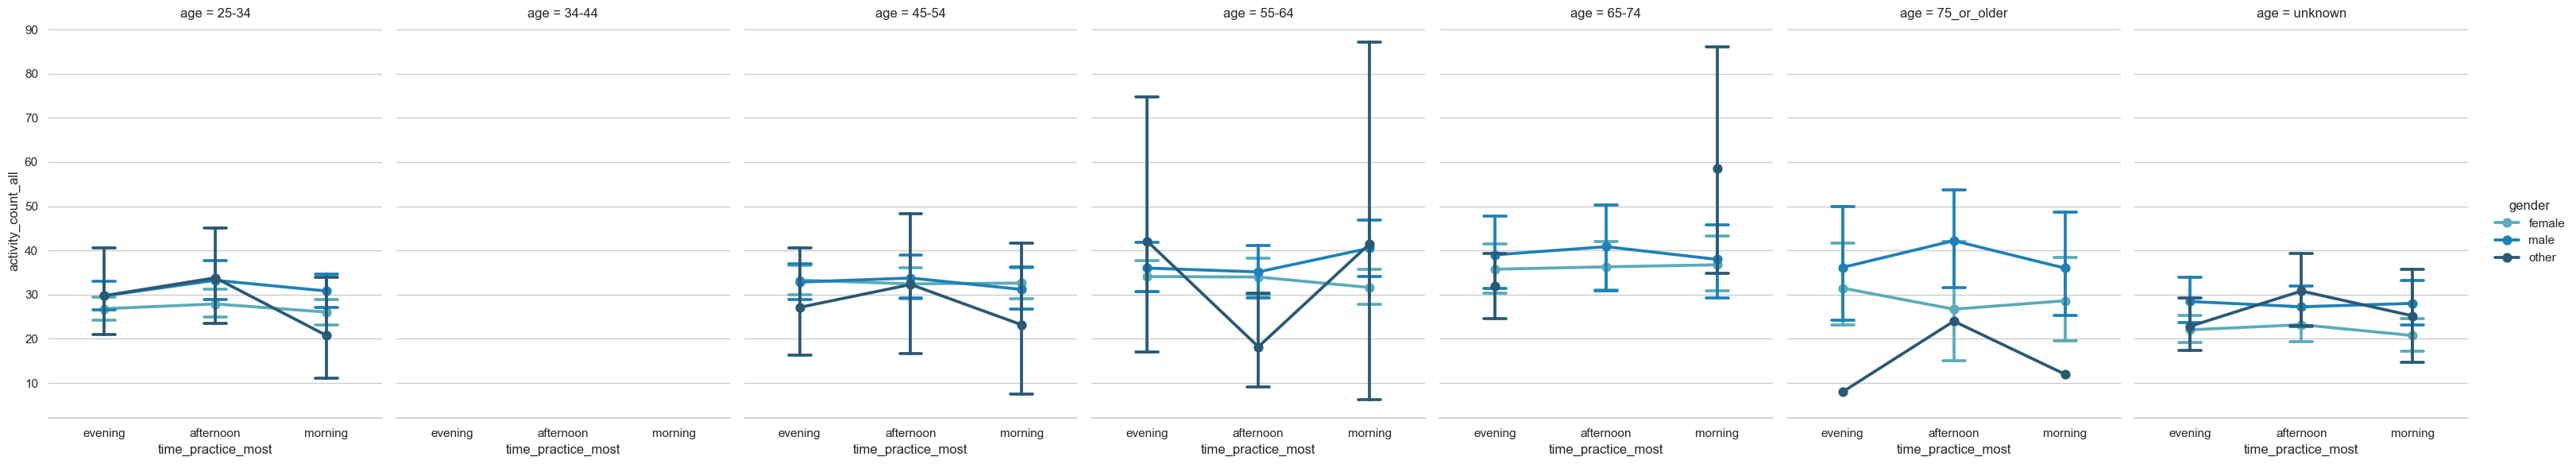

In [241]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=df_sorted_all_activity, x="time_practice_most", y="activity_count_all", hue = 'gender', col="age",
    capsize=.2, palette="YlGnBu_d", errorbar="ci",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

In [232]:
plt.savefig('3_way_anova.png')

<Figure size 640x480 with 0 Axes>

/var/folders/t5/jyb99b0d5rd5j2hh_d16njs40000gn/T/ipykernel_8850/2383886648.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


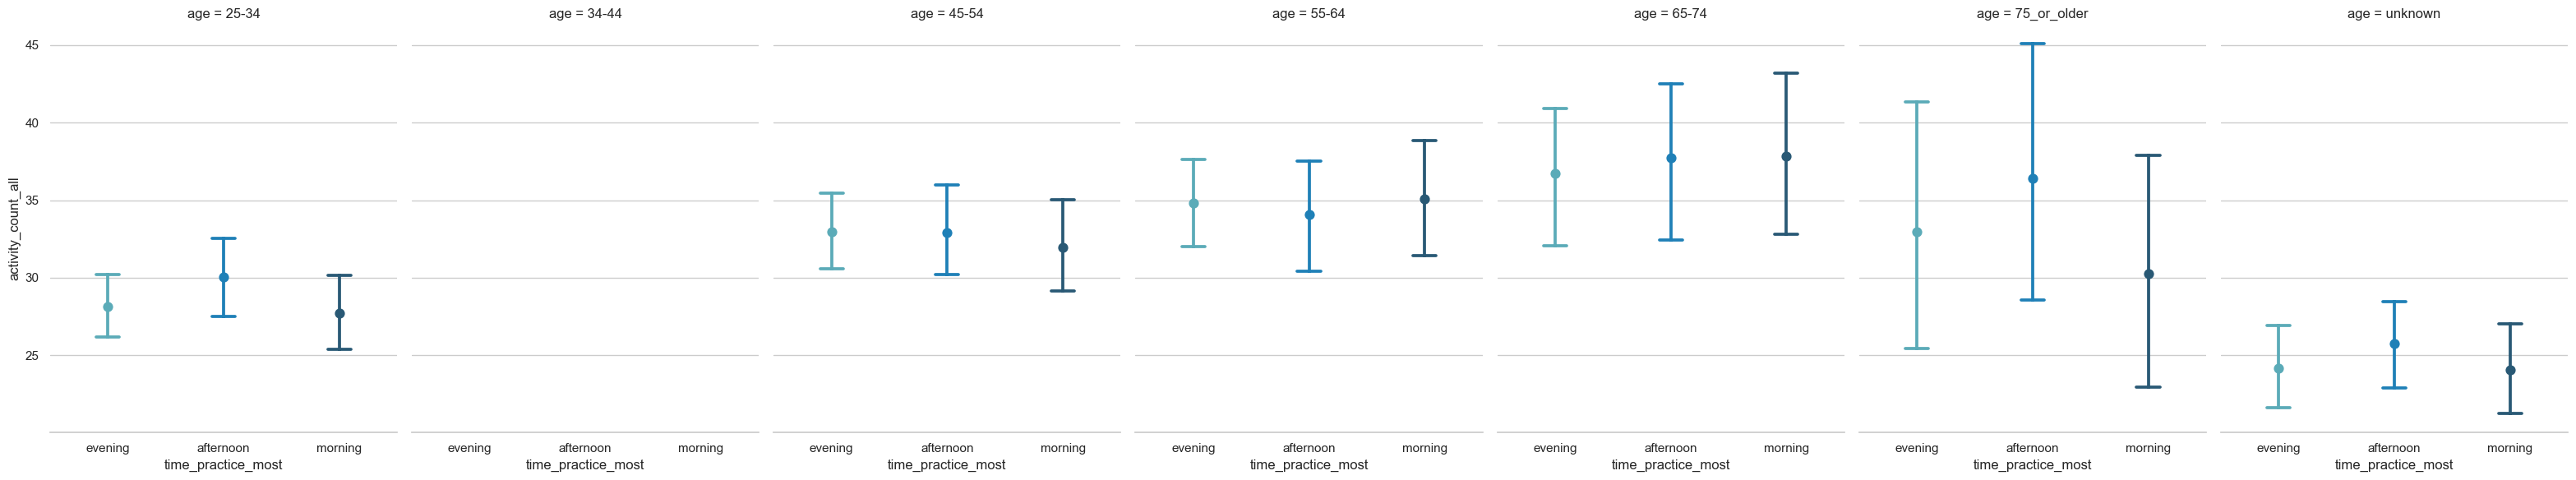

In [218]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=df_merged_all_activity, x="time_practice_most", y="activity_count_all", col="age",
    capsize=.2, palette="YlGnBu_d", errorbar="ci",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

### Adding Interaction Between 'time_practice_most' and 'age'

In [155]:
# interaction
model_interaction_1 = smf.glm(
    formula="activity_count_all ~ C(time_practice_most) * C(age)",
    data=df_merged_all_activity, # df_1 + demographics
    family=sm.families.NegativeBinomial()
).fit()

model_interaction_1.summary()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     activity_count_all   No. Observations:                 5304
Model:                            GLM   Df Residuals:                     5286
Model Family:        NegativeBinomial   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23581.
Date:                Wed, 19 Nov 2025   Deviance:                       4987.0
Time:                        23:56:09   Pearson chi2:                 4.07e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02154
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  3.3610      0.048     70.013      0.000       3.267       3.455
C(time_practice_most)[T.evening]                          -0.0707      0.064     -1.109      0.268      -0.196       0.054
C(time_practice_most)[T.morning]                           0.0796      0.072      1.100      0.271      -0.062       0.221
C(age)[T.34-44]                                         5.219e-17   1.25e-16      0.419      0.675   -1.92e-16    2.96e-16
C(age)[T.45-54]                                            0.0144      0.068      0.212      0.832      -0.119       0.148
C(age)[T.55-64]                                            0.1666      0.070      2.380      0.017       0.029       0.304
C(age)[T.65-74]                                            0.3230      0.083      3.906      0.000       0.161       0.485
C(age)[T.75_or_older]                                      0.0132      0.145      0.091      0.928      -0.272       0.298
C(age)[T.unknown]                                         -0.1242      0.082     -1.510      0.131      -0.285       0.037
C(time_practice_most)[T.evening]:C(age)[T.34-44]        5.655e-17   8.21e-17      0.689      0.491   -1.04e-16    2.17e-16
C(time_practice_most)[T.morning]:C(age)[T.34-44]        6.526e-17   4.51e-17      1.447      0.148   -2.31e-17    1.54e-16
C(time_practice_most)[T.evening]:C(age)[T.45-54]           0.2072      0.090      2.298      0.022       0.030       0.384
C(time_practice_most)[T.morning]:C(age)[T.45-54]           0.1166      0.102      1.139      0.255      -0.084       0.317
C(time_practice_most)[T.evening]:C(age)[T.55-64]           0.0102      0.096      0.105      0.916      -0.179       0.199
C(time_practice_most)[T.morning]:C(age)[T.55-64]           0.0929      0.112      0.832      0.405      -0.126       0.312
C(time_practice_most)[T.evening]:C(age)[T.65-74]          -0.0483      0.115     -0.418      0.676      -0.275       0.178
C(time_practice_most)[T.morning]:C(age)[T.65-74]          -0.1788      0.146     -1.221      0.222      -0.466       0.108
C(time_practice_most)[T.evening]:C(age)[T.75_or_older]     0.1079      0.191      0.564      0.573      -0.267       0.483
C(time_practice_most)[T.morning]:C(age)[T.75_or_older]     0.4289      0.243      1.762      0.078      -0.048       0.906
C(time_practice_most)[T.evening]:C(age)[T.unknown]        -0.0272      0.105     -0.258      0.796      -0.234       0.179
C(time_practice_most)[T.morning]:C(age)[T.unknown]        -0.0195      0.123     -0.159      0.874      -0.261       0.222
==========================================================================================================================
"""

In [163]:
np.exp(model_cov_1.params)

Intercept                           27.955252
C(time_practice_most)[T.evening]     0.977670
C(time_practice_most)[T.morning]     1.127403
C(age)[T.34-44]                      1.000000
C(age)[T.45-54]                      1.143429
C(age)[T.55-64]                      1.214566
C(age)[T.65-74]                      1.323914
C(age)[T.75_or_older]                1.165589
C(age)[T.unknown]                    0.866013
dtype: float64

### total_score(df_2)

In [166]:
df_2 # 8499 rows × 3 columns

,user_id,total_score,time_practice_most
0,us-east-1:0004187c-f54f-4590-bde8-9cd9cc375b7f,5,afternoon
31,us-east-1:00198846-bbca-4e33-9420-d3d0413b4858,4,evening
55,us-east-1:001d3487-2fa2-429b-bdb1-509b1840d7c6,4,afternoon
124,us-east-1:0033b748-f290-4b4c-a6e9-61fc7839e37a,2,morning
130,us-east-1:003820ca-07dd-40f9-b282-4ab65b02dfa2,10,afternoon
...,...,...,...
290717,us-east-1:ffe47cd3-d901-4617-b457-a2fbc0ea77c9,2,evening
290730,us-east-1:ffe65c7f-2455-497e-9946-7b7024716ae2,2,morning
290733,us-east-1:ffea8ac5-d7af-495f-ba4c-1ea85b068f65,2,morning
290742,us-east-1:fff29fd9-f458-423d-8679-a12298c43baf,3,evening


In [168]:
df_merged_score = pd.merge(df_2, demographic, on="user_id", how="left")
df_merged_score
# outer join: 6845 rows × 8 columns
# left join: 8499 rows × 8 columns

,user_id,total_score,time_practice_most,education,age,relationship,gender,race
0,us-east-1:0004187c-f54f-4590-bde8-9cd9cc375b7f,5,afternoon,bachelors_degree,25-34,divorced,female,white
1,us-east-1:00198846-bbca-4e33-9420-d3d0413b4858,4,evening,advanced_degree,NaN,married_domestic_part,male,white
2,us-east-1:001d3487-2fa2-429b-bdb1-509b1840d7c6,4,afternoon,NaN,NaN,NaN,NaN,NaN
3,us-east-1:0033b748-f290-4b4c-a6e9-61fc7839e37a,2,morning,advanced_degree,NaN,married_domestic_part,female,other
4,us-east-1:003820ca-07dd-40f9-b282-4ab65b02dfa2,10,afternoon,advanced_degree,25-34,committed,female,white
...,...,...,...,...,...,...,...,...
8494,us-east-1:ffe47cd3-d901-4617-b457-a2fbc0ea77c9,2,evening,high_school,45-54,married_domestic_part,male,white
8495,us-east-1:ffe65c7f-2455-497e-9946-7b7024716ae2,2,morning,advanced_degree,45-54,single_never_married,female,white
8496,us-east-1:ffea8ac5-d7af-495f-ba4c-1ea85b068f65,2,morning,bachelors_degree,45-54,married_domestic_part,female,white
8497,us-east-1:fff29fd9-f458-423d-8679-a12298c43baf,3,evening,advanced_degree,NaN,single_never_married,female,white


/var/folders/t5/jyb99b0d5rd5j2hh_d16njs40000gn/T/ipykernel_8850/3685868398.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="time_practice_most", y="total_score", data=df_merged_score, inner="box", palette="Pastel1")


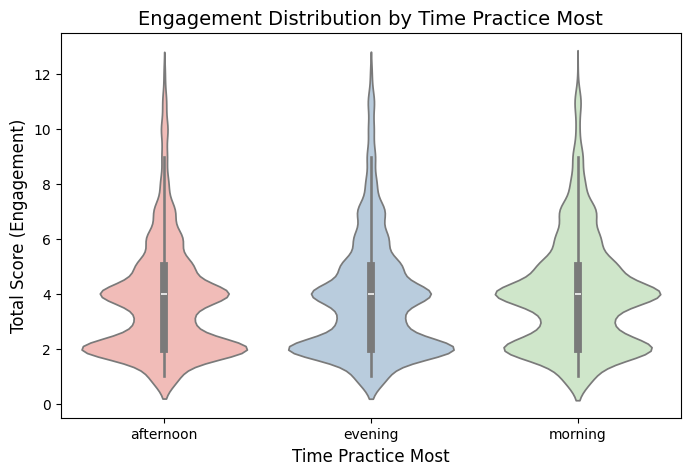

In [170]:
plt.figure(figsize=(8, 5))
sns.violinplot(x="time_practice_most", y="total_score", data=df_merged_score, inner="box", palette="Pastel1")

plt.title("Engagement Distribution by Time Practice Most", fontsize=14)
plt.xlabel("Time Practice Most", fontsize=12)
plt.ylabel("Total Score (Engagement)", fontsize=12)
plt.show()

### check correlation

In [173]:
# check correlation
model = ols('total_score ~ C(time_practice_most)', data=df_merged_score).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
eta_sq = anova_table['sum_sq']['C(time_practice_most)'] / sum(anova_table['sum_sq'])
print("Eta squared:", eta_sq)

Eta squared: 0.002440152550105662


In [175]:
model = ols('total_score ~ C(gender)', data=df_merged_score).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
eta_sq = anova_table['sum_sq']['C(gender)'] / sum(anova_table['sum_sq'])
print("Eta squared:", eta_sq)

Eta squared: 7.478269483446567e-06


In [177]:
model = ols('total_score ~ C(race)', data=df_merged_score).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
eta_sq = anova_table['sum_sq']['C(race)'] / sum(anova_table['sum_sq'])
print("Eta squared:", eta_sq)

Eta squared: 0.001690984333090405


In [179]:
model = ols('total_score ~ C(education)', data=df_merged_score).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
eta_sq = anova_table['sum_sq']['C(education)'] / sum(anova_table['sum_sq'])
print("Eta squared:", eta_sq)

Eta squared: 0.004097201134670923


In [181]:
model = ols('total_score ~ C(age)', data=df_merged_score).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
eta_sq = anova_table['sum_sq']['C(age)'] / sum(anova_table['sum_sq'])
print("Eta squared:", eta_sq)

Eta squared: 0.020759078478653135


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  warnings.warn('covariance of constraints does not have full '


### models df_2 + demographics

In [199]:
df_merged_score.describe()

,total_score
count,8499.000000
mean,3.798800
std,2.061708
min,1.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,12.000000


In [194]:
model_nb = smf.glm(
    formula="total_score ~ C(time_practice_most)",
    data=df_merged_score, # df_2 + demographics
    family=sm.families.NegativeBinomial()
).fit()

model_nb.summary()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_score   No. Observations:                 8499
Model:                            GLM   Df Residuals:                     8496
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20872.
Date:                Thu, 20 Nov 2025   Deviance:                       1858.4
Time:                        10:55:09   Pearson chi2:                 1.98e+03
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0005617
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.3082      0.021     62.050      0.000       1.267       1.350
C(time_practice_most)[T.evening]     0.0221      0.028      0.787      0.432      -0.033       0.077
C(time_practice_most)[T.morning]     0.0706      0.033      2.161      0.031       0.007       0.135
====================================================================================================
"""

In [196]:
# no need to model since eta squared is too small, only age's eta squared > 0.01 show small correlation
model_nb = smf.glm(
    formula="total_score ~ C(time_practice_most) + C(age)",
    data=df_merged_score,
    family=sm.families.NegativeBinomial()
).fit()

model_nb.summary()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_score   No. Observations:                 5362
Model:                            GLM   Df Residuals:                     5354
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13092.
Date:                Thu, 20 Nov 2025   Deviance:                       1137.7
Time:                        10:55:12   Pearson chi2:                 1.20e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.004529
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.2374      0.037     33.012      0.000       1.164       1.311
C(time_practice_most)[T.evening]     0.0114      0.036      0.321      0.748      -0.058       0.081
C(time_practice_most)[T.morning]     0.0692      0.041      1.669      0.095      -0.012       0.150
C(age)[T.34-44]                   8.146e-17   3.38e-17      2.411      0.016    1.52e-17    1.48e-16
C(age)[T.45-54]                      0.0688      0.043      1.614      0.107      -0.015       0.152
C(age)[T.55-64]                      0.1263      0.046      2.730      0.006       0.036       0.217
C(age)[T.65-74]                      0.1782      0.057      3.140      0.002       0.067       0.289
C(age)[T.75_or_older]                0.1870      0.092      2.028      0.043       0.006       0.368
C(age)[T.unknown]                   -0.0398      0.050     -0.798      0.425      -0.138       0.058
====================================================================================================
"""

In [188]:
# no need to model since eta squared is too small, only age's eta squared > 0.01 show small correlation
model_score_interaction = smf.glm(
    formula="total_score ~ C(time_practice_most) * C(age)",
    data=df_merged_score,
    family=sm.families.NegativeBinomial()
).fit()

model_score_interaction.summary()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            total_score   No. Observations:                 5362
Model:                            GLM   Df Residuals:                     5344
Model Family:        NegativeBinomial   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13089.
Date:                Wed, 19 Nov 2025   Deviance:                       1132.8
Time:                        23:59:06   Pearson chi2:                 1.19e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.005440
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  1.2584      0.053     23.662      0.000       1.154       1.363
C(time_practice_most)[T.evening]                          -0.0376      0.071     -0.531      0.595      -0.177       0.101
C(time_practice_most)[T.morning]                           0.0663      0.080      0.832      0.405      -0.090       0.222
C(age)[T.34-44]                                          1.03e-16   8.33e-17      1.237      0.216   -6.03e-17    2.66e-16
C(age)[T.45-54]                                           -0.0082      0.075     -0.109      0.913      -0.156       0.140
C(age)[T.55-64]                                            0.1038      0.077      1.342      0.179      -0.048       0.255
C(age)[T.65-74]                                            0.2172      0.090      2.403      0.016       0.040       0.394
C(age)[T.75_or_older]                                      0.0961      0.159      0.604      0.546      -0.216       0.408
C(age)[T.unknown]                                         -0.0400      0.092     -0.436      0.663      -0.219       0.140
C(time_practice_most)[T.evening]:C(age)[T.34-44]        2.996e-17   9.75e-17      0.307      0.759   -1.61e-16    2.21e-16
C(time_practice_most)[T.morning]:C(age)[T.34-44]         1.49e-16   2.34e-16      0.637      0.524    -3.1e-16    6.08e-16
C(time_practice_most)[T.evening]:C(age)[T.45-54]           0.1433      0.100      1.433      0.152      -0.053       0.339
C(time_practice_most)[T.morning]:C(age)[T.45-54]           0.0613      0.113      0.543      0.587      -0.160       0.282
C(time_practice_most)[T.evening]:C(age)[T.55-64]           0.0511      0.106      0.481      0.631      -0.157       0.259
C(time_practice_most)[T.morning]:C(age)[T.55-64]           0.0062      0.123      0.050      0.960      -0.234       0.247
C(time_practice_most)[T.evening]:C(age)[T.65-74]          -0.0315      0.127     -0.249      0.804      -0.280       0.217
C(time_practice_most)[T.morning]:C(age)[T.65-74]          -0.1695      0.160     -1.062      0.288      -0.482       0.143
C(time_practice_most)[T.evening]:C(age)[T.75_or_older]     0.1076      0.209      0.515      0.606      -0.302       0.517
C(time_practice_most)[T.morning]:C(age)[T.75_or_older]     0.2149      0.262      0.820      0.412      -0.299       0.728
C(time_practice_most)[T.evening]:C(age)[T.unknown]         0.0226      0.117      0.193      0.847      -0.208       0.253
C(time_practice_most)[T.morning]:C(age)[T.unknown]        -0.0320      0.137     -0.234      0.815      -0.300       0.236
==========================================================================================================================
"""

In [234]:
time_order = ['evening', 'afternoon', 'morning']
df_merged_score['time_practice_most'] = df['time_practice_most'].astype(pd.CategoricalDtype(categories=time_order, ordered=True))
df_sorted_score = df_merged_score.sort_values('time_practice_most')

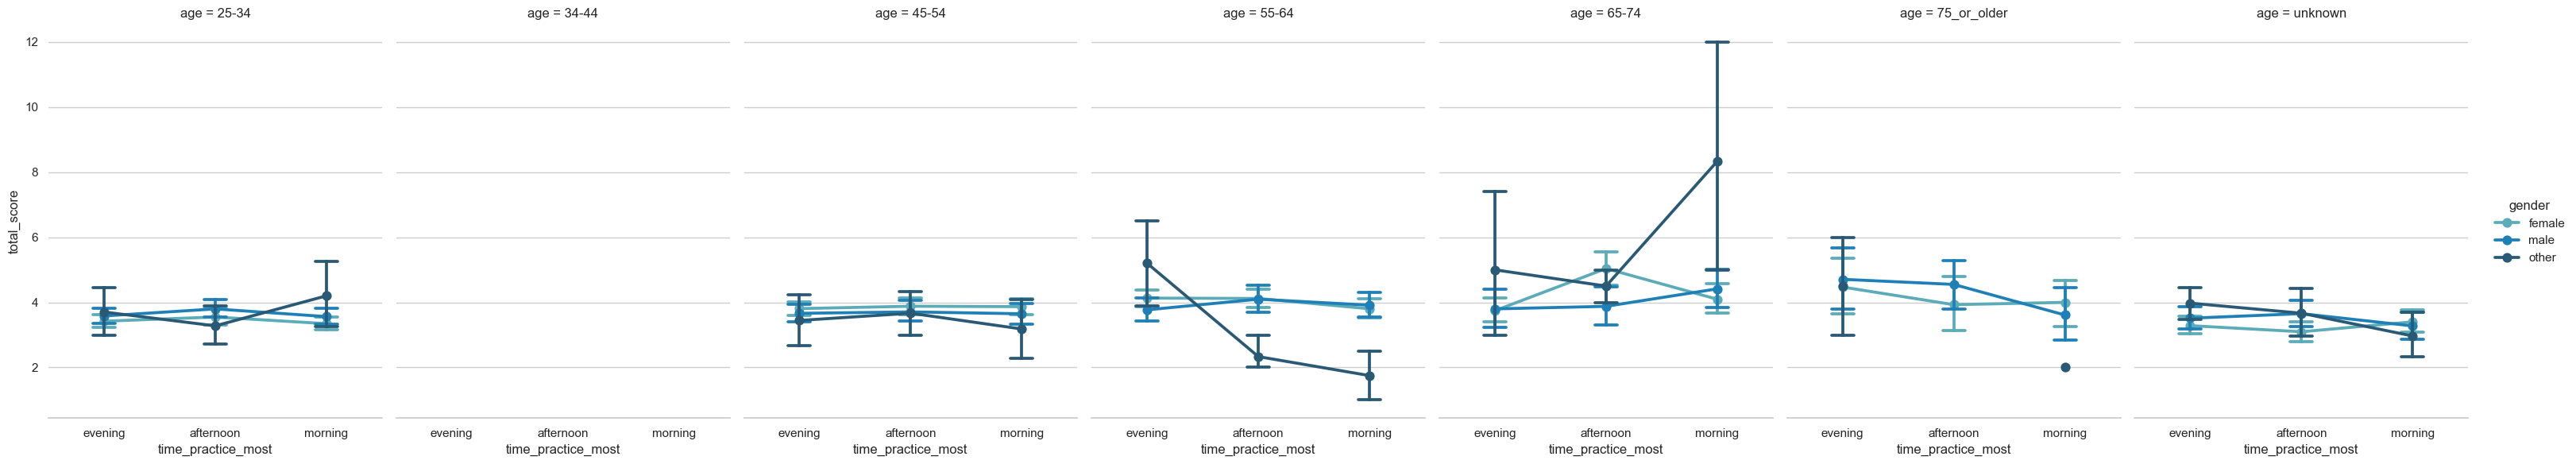

In [236]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=df_sorted_score, x="time_practice_most", y="total_score", hue = 'gender', col="age",
    capsize=.2, palette="YlGnBu_d", errorbar="ci",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)